In [1]:
EPOCHS = 10 
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 5

In [2]:

import os

models_path=''

COLAB=True
import gc
!pip install fsspec
!pip install gcsfs 
!pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Cassava/'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

database_base_path = 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028'
GCS_PATH = 'gs://kds-97ffa76638f61f952661d26d7752f59abdf8f804f1e4794ab6b2e297'
GCS_PATH_EXT = 'gs://kds-e707b2c823f5ab0df2845ed8abcbed536d27e188731770fde8a6a95b'
GCS_PATH_CLASSES = 'gs://kds-df6e525a58ba9104b570dd12c9abca118c8a509b740d9164e4cd4de3'
GCS_PATH_EXT_CLASSES = 'gs://kds-7e729109c97bb2badcc4d6ec847c47b388513403e0c35cfc68b5ae02'


# 
#This is a path to a dataset that changes over time, so you need to constantly update it. To update the path just run the code: 
#GCS_DS_PATH = KaggleDatasets (). Get_gcs_path ()
#print (GCS_PATH)......
models_path='/content/drive/MyDrive/Colab Notebooks/Cassava/model/'# I created a folder called Models/Cassava on my Google Drive

     |████████████████████████████████| 102kB 4.8MB/s 
     |████████████████████████████████| 1.3MB 7.3MB/s 
     |████████████████████████████████| 143kB 19.5MB/s 
     |████████████████████████████████| 296kB 18.7MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=02b9fe0ff8662dae52d6a4928c48dc47ffde0e9a2d60d70dcf76b93757e83bfa
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=f5b1e81071b426cac41664f2d07c10afce34db5c4a4002793b44af898ed71688
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
Mounted at /content/drive
/c

In [3]:
if COLAB:# Prepare the kaggle.json file for use 
    from google.colab import files
    if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
        !mkdir ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json'):
            files.upload()
            !cp kaggle.json ~/content/drive/MyDrive/Colab Notebooks/.kaggle/
        else:
            !cp '/content/drive/MyDrive/Colab Notebooks/' ~/.kaggle/  
        !chmod 600 ~/content/drive/MyDrive/Colab Notebooks/.kaggle/kaggle.json


In [4]:
if COLAB:# force TF to 2.2
    !pip install -q tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
    
    import requests
    import os
    import tensorflow as tf
    resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
    if resp.status_code != 200:
      print("Failed to switch the TPU to TF {}".format(version))

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 399kB 36.5MB/s 
     |████████████████████████████████| 460kB 52.2MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 3.0MB 53.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## Dependencies

In [5]:
import math, os, re, warnings, random, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

Note that we have `32` cores, this is because the `TPU v2 Pod` have more cores than a single `TPU v3` which has `8` cores.

In [6]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None
    print ('tpu',tpu)

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.119.160.210:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


# Model parameters

In [7]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS

# Load data

In [8]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


train = pd.read_csv(f'{database_base_path}/train.csv')
print(f'Train samples: {len(train)}')

FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')


TRAINING_FILENAMES = (FILENAMES_COMP + 
                      FILENAMES_2019 + 
                      (2 * FILENAMES_COMP_CBB) + 
                      (2 * FILENAMES_2019_CBB) + 
                      (2 * FILENAMES_COMP_CBSD) + 
                      (2 * FILENAMES_2019_CBSD) + 
                      (2 * FILENAMES_COMP_CGM) + 
                      (2 * FILENAMES_2019_CGM) + 
                      (2 * FILENAMES_COMP_Healthy) + 
                      (2 * FILENAMES_2019_Healthy))

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 21397
GCS: train images: 48081


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [9]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [10]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [11]:
# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT_RS, WIDTH_RS])
    image = tf.reshape(image, [HEIGHT_RS, WIDTH_RS, 3])
    return image, label

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
                
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

In [12]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['accuracy'], label='Train accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Training data samples (with augmentation)

In [13]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Output hidden; open in https://colab.research.google.com to view.

## Datasets distribution

### Competition data

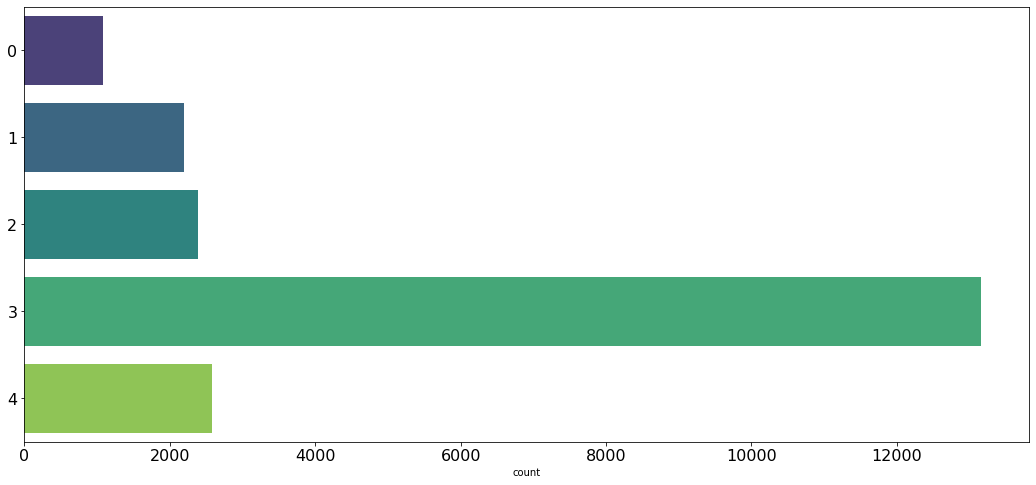

In [14]:
ds_comp = get_dataset(FILENAMES_COMP)
labels_comp = [target.numpy() for img, target in iter(ds_comp.unbatch())]
labels_comp = np.argmax(labels_comp, axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=labels_comp, palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

### 2019 competition data

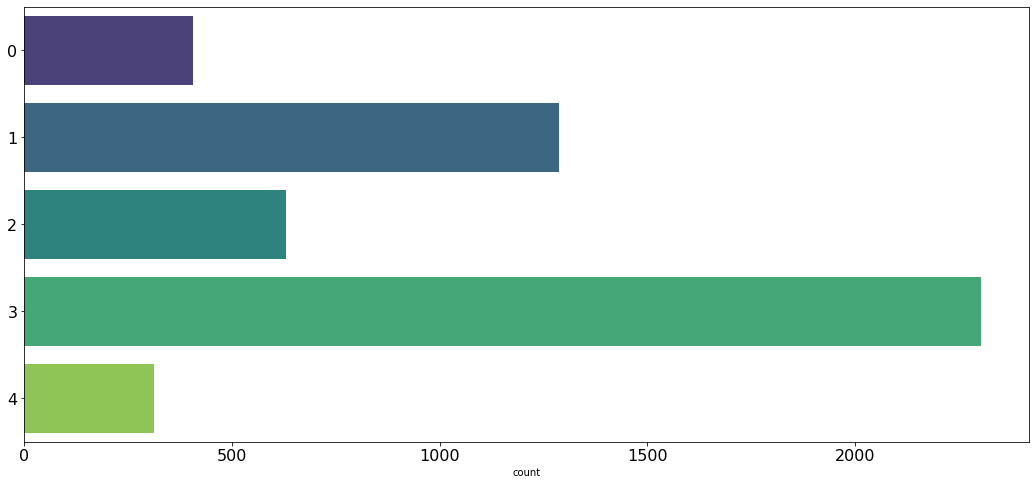

In [15]:
ds_2019 = get_dataset(FILENAMES_2019)
labels_2019 = [target.numpy() for img, target in iter(ds_2019.unbatch())]
labels_2019 = np.argmax(labels_2019, axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=labels_2019, palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

### Dataset oversampled

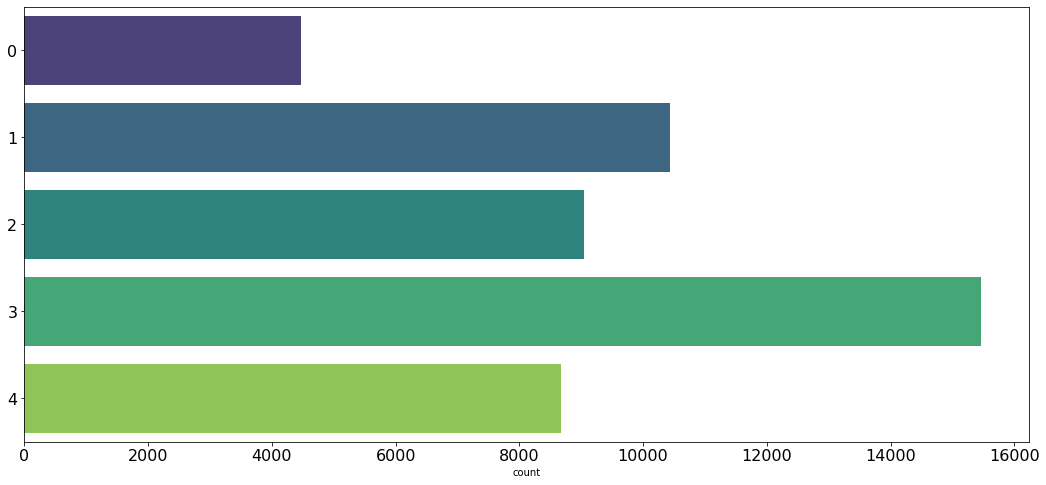

In [16]:
FILENAMES_COMP_OVER = (FILENAMES_COMP + 
                       FILENAMES_2019 + 
                       (2 * FILENAMES_COMP_CBB) + 
                       (2 * FILENAMES_2019_CBB) + 
                       (2 * FILENAMES_COMP_CBSD) + 
                       (2 * FILENAMES_2019_CBSD) + 
                       (2 * FILENAMES_COMP_CGM) + 
                       (2 * FILENAMES_2019_CGM) + 
                       (2 * FILENAMES_COMP_Healthy) + 
                       (2 * FILENAMES_2019_Healthy))

ds_comp = get_dataset(FILENAMES_COMP_OVER)
labels_comp = [target.numpy() for img, target in iter(ds_comp.unbatch())]
labels_comp = np.argmax(labels_comp, axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=labels_comp, palette='viridis')
ax.tick_params(labelsize=16)

plt.show()

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

7510 total steps and 751 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-08


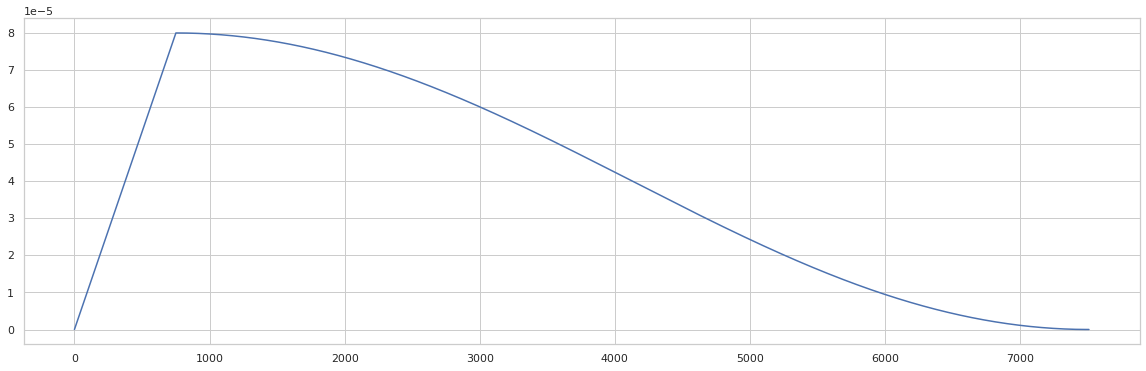

In [17]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = LEARNING_RATE
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = EPOCHS
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def lrfn(step):
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, float(lr))

    return lr


# rng = [i for i in range(total_epochs)]
rng = [i for i in range(total_steps)]
y = [lrfn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

In [18]:
from tensorflow.keras.applications import Xception
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = Xception(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
    base_model.trainable = False
    x = L.Dropout(.5)(base_model.output)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [19]:
#help(strategy)

# Training

In [20]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(50))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

    FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
    FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + 
                       FILENAMES_2019 + 
                       (2 * FILENAMES_COMP_CBB) + 
                       (2 * FILENAMES_2019_CBB) + 
                       (2 * FILENAMES_COMP_CBSD) + 
                       (2 * FILENAMES_2019_CBSD) + 
                       (2 * FILENAMES_COMP_CGM) + 
                       (2 * FILENAMES_2019_CGM) + 
                       (2 * FILENAMES_COMP_Healthy) + 
                       (2 * FILENAMES_2019_Healthy))
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps=(total_epochs * step_size)
    warmup_steps=(warmup_epochs * step_size)
    
    
    # Build TF datasets
    train_ds = strategy.experimental_distribute_dataset(get_dataset(TRAIN_FILENAMES, repeated=True, augment=True))
    valid_ds = strategy.experimental_distribute_dataset(get_dataset(VALID_FILENAMES, ordered=True, repeated=True, cached=True))
    train_data_iter = iter(train_ds)
    valid_data_iter = iter(valid_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities, label_smoothing=.3)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # update metrics
            train_accuracy.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            if COLAB:
                #print(COLAB)
                strategy.experimental_run_v2(train_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            # update metrics
            valid_accuracy.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            if COLAB:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
            else:
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    
    # Model
    model_path = models_path+f'model_{fold}.h5'
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)))
        loss_fn = losses.categorical_crossentropy

        train_accuracy = metrics.CategoricalAccuracy()
        valid_accuracy = metrics.CategoricalAccuracy()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
    
    
    # Setup training loop
    step = 0
    epoch_steps = 0
    patience_cnt = 0
    best_val = 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    ### Train model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Run training step
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size
            

        # Validation run at the end of each epoch
        if (step // step_size) > epoch:
            # Validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # Compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE * valid_epoch_steps))

            # Report metrics
            epoch_time = time.time() - epoch_start_time
            print(f'\nEPOCH {epoch+1}/{EPOCHS}')
            print(f'time: {epoch_time:0.1f}s',
                  f"loss: {history['loss'][-1]:0.4f}",
                  f"accuracy: {history['accuracy'][-1]:0.4f}",
                  f"val_loss: {history['val_loss'][-1]:0.4f}",
                  f"val_accuracy: {history['val_accuracy'][-1]:0.4f}",
                  f'lr: {lrfn(tf.cast(optimizer.iterations, tf.int32).numpy()):0.4g}')

            # Early stopping monitor
            if history['val_accuracy'][-1] >= best_val:
                best_val = history['val_accuracy'][-1]
                model.save_weights(model_path)
                print(f'Saved model weights at "{model_path}"')
                patience_cnt = 1
            else:
                patience_cnt += 1
            # if patience_cnt > ES_PATIENCE:
            #     print(f'Epoch {epoch:05d}: early stopping')
            #     break

                
            # Set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            train_accuracy.reset_states()
            train_loss.reset_states()
            valid_accuracy.reset_states()
            valid_loss.reset_states()
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 0  1  3 ... 47 48 49] VALID: [ 2  4 10 11 22 27 28 31 38 41]
83689472/83683744 [==============================] - 1s 0us/step
Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`



EPOCH 1/10
time: 205.9s loss: 1.3046 accuracy: 0.6270 val_loss: 0.6878 val_accuracy: 0.8352 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 2/10
time: 144.8s loss: 1.1371 accuracy: 0.7967 val_loss: 0.5479 val_accuracy: 0.8632 lr: 7.759e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 3/10
time: 147.3s loss: 1.1050 accuracy: 0.8242 val_loss: 0.5948 val_accuracy: 0.8584 lr: 7.064e-05

EPOCH 4/10


time: 143.8s loss: 1.0857 accuracy: 0.8417 val_loss: 0.5318 val_accuracy: 0.8748 lr: 6e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 5/10


time: 152.2s loss: 1.0707 accuracy: 0.8526 val_loss: 0.5359 val_accuracy: 0.8840 lr: 4.695e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 6/10


time: 133.8s loss: 1.0595 accuracy: 0.8626 val_loss: 0.5293 val_accuracy: 0.8835 lr: 3.305e-05

EPOCH 7/10


time: 143.8s loss: 1.0456 accuracy: 0.8739 val_loss: 0.5191 val_accuracy: 0.8857 lr: 2e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 8/10


time: 135.0s loss: 1.0368 accuracy: 0.8821 val_loss: 0.5159 val_accuracy: 0.8880 lr: 9.358e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_0.h5"

EPOCH 9/10


time: 140.9s loss: 1.0304 accuracy: 0.8865 val_loss: 0.5208 val_accuracy: 0.8857 lr: 2.412e-06

EPOCH 10/10


time: 142.7s loss: 1.0294 accuracy: 0.8889 val_loss: 0.5328 val_accuracy: 0.8835 lr: 8e-05
#### FOLD 1 OOF Accuracy = 0.888


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2 ... 46 47 49] VALID: [ 7 14 18 26 29 33 34 35 45 48]



EPOCH 1/10
time: 207.1s loss: 1.2948 accuracy: 0.6364 val_loss: 0.6302 val_accuracy: 0.8369 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 2/10
time: 146.5s loss: 1.1356 accuracy: 0.8010 val_loss: 0.5850 val_accuracy: 0.8684 lr: 7.759e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 3/10
time: 149.8s loss: 1.1035 accuracy: 0.8273 val_loss: 0.5254 val_accuracy: 0.8738 lr: 7.064e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 4/10


time: 145.2s loss: 1.0847 accuracy: 0.8413 val_loss: 0.5938 val_accuracy: 0.8700 lr: 6e-05

EPOCH 5/10


time: 142.7s loss: 1.0712 accuracy: 0.8528 val_loss: 0.5464 val_accuracy: 0.8819 lr: 4.695e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 6/10


time: 136.8s loss: 1.0579 accuracy: 0.8623 val_loss: 0.5292 val_accuracy: 0.8781 lr: 3.305e-05

EPOCH 7/10


time: 143.9s loss: 1.0470 accuracy: 0.8732 val_loss: 0.5175 val_accuracy: 0.8821 lr: 2e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 8/10


time: 135.6s loss: 1.0363 accuracy: 0.8815 val_loss: 0.5179 val_accuracy: 0.8857 lr: 9.358e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_1.h5"

EPOCH 9/10


time: 138.3s loss: 1.0313 accuracy: 0.8886 val_loss: 0.5181 val_accuracy: 0.8842 lr: 2.412e-06

EPOCH 10/10


time: 142.0s loss: 1.0272 accuracy: 0.8901 val_loss: 0.5288 val_accuracy: 0.8821 lr: 8e-05
#### FOLD 2 OOF Accuracy = 0.886


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  1  2 ... 47 48 49] VALID: [ 8 13 15 16 20 25 30 32 42 43]



EPOCH 1/10
time: 209.5s loss: 1.3136 accuracy: 0.6171 val_loss: 0.6449 val_accuracy: 0.8461 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 2/10
time: 146.9s loss: 1.1326 accuracy: 0.8024 val_loss: 0.5865 val_accuracy: 0.8449 lr: 7.759e-05

EPOCH 3/10
time: 149.8s loss: 1.1024 accuracy: 0.8255 val_loss: 0.5494 val_accuracy: 0.8764 lr: 7.064e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 4/10
time: 145.3s loss: 1.0835 accuracy: 0.8423 val_loss: 0.5335 val_accuracy: 0.8804 lr: 6e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 5/10
time: 144.0s loss: 1.0690 accuracy: 0.8522 val_loss: 0.5417 val_accuracy: 0.8752 lr: 4.695e-05

EPOCH 6/10
time: 139.1s loss: 1.0592 accuracy: 0.8607 val_loss: 0.5341 val_accuracy: 0.8819 lr: 3.305e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_2.h5"

EPOCH 7/1

INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  2  3 ... 46 47 48] VALID: [ 1  5  6 12 17 23 24 37 40 49]

EPOCH 1/10
time: 212.9s loss: 1.3156 accuracy: 0.6136 val_loss: 0.6121 val_accuracy: 0.8598 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 2/10
time: 154.2s loss: 1.1378 accuracy: 0.7952 val_loss: 0.5219 val_accuracy: 0.8738 lr: 7.759e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 3/10
time: 149.1s loss: 1.1093 accuracy: 0.8186 val_loss: 0.5942 val_accuracy: 0.8530 lr: 7.064e-05

EPOCH 4/10


time: 154.1s loss: 1.0885 accuracy: 0.8376 val_loss: 0.5188 val_accuracy: 0.8878 lr: 6e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 5/10


time: 142.6s loss: 1.0733 accuracy: 0.8508 val_loss: 0.5084 val_accuracy: 0.8873 lr: 4.695e-05

EPOCH 6/10


time: 144.3s loss: 1.0615 accuracy: 0.8591 val_loss: 0.5207 val_accuracy: 0.8897 lr: 3.305e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 7/10


time: 140.5s loss: 1.0479 accuracy: 0.8709 val_loss: 0.5178 val_accuracy: 0.8873 lr: 2e-05

EPOCH 8/10


time: 143.9s loss: 1.0387 accuracy: 0.8793 val_loss: 0.5092 val_accuracy: 0.8909 lr: 9.358e-06
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_3.h5"

EPOCH 9/10


time: 142.3s loss: 1.0313 accuracy: 0.8851 val_loss: 0.5189 val_accuracy: 0.8902 lr: 2.412e-06

EPOCH 10/10


time: 142.6s loss: 1.0291 accuracy: 0.8886 val_loss: 0.5319 val_accuracy: 0.8883 lr: 8e-05
#### FOLD 4 OOF Accuracy = 0.891


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.160.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 1  2  4 ... 45 48 49] VALID: [ 0  3  9 19 21 36 39 44 46 47]



EPOCH 1/10
time: 214.2s loss: 1.3109 accuracy: 0.6141 val_loss: 0.5972 val_accuracy: 0.8653 lr: 8e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 2/10
time: 154.6s loss: 1.1383 accuracy: 0.7963 val_loss: 0.5884 val_accuracy: 0.8556 lr: 7.759e-05

EPOCH 3/10
time: 149.4s loss: 1.1071 accuracy: 0.8217 val_loss: 0.5696 val_accuracy: 0.8738 lr: 7.064e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 4/10
time: 155.5s loss: 1.0855 accuracy: 0.8395 val_loss: 0.5357 val_accuracy: 0.8859 lr: 6e-05
Saved model weights at "/content/drive/MyDrive/Colab Notebooks/Cassava/model/model_4.h5"

EPOCH 5/10
time: 143.2s loss: 1.0743 accuracy: 0.8493 val_loss: 0.5416 val_accuracy: 0.8845 lr: 4.695e-05

EPOCH 6/10
time: 143.7s loss: 1.0609 accuracy: 0.8595 val_loss: 0.5229 val_accuracy: 0.8816 lr: 3.305e-05

EPOCH 7/10
time: 142.0s loss: 1.0471 accuracy: 0.8709 val_loss: 0.5237 val_accuracy: 0.8857 lr: 2e

## Model loss graph


FOLD: 1


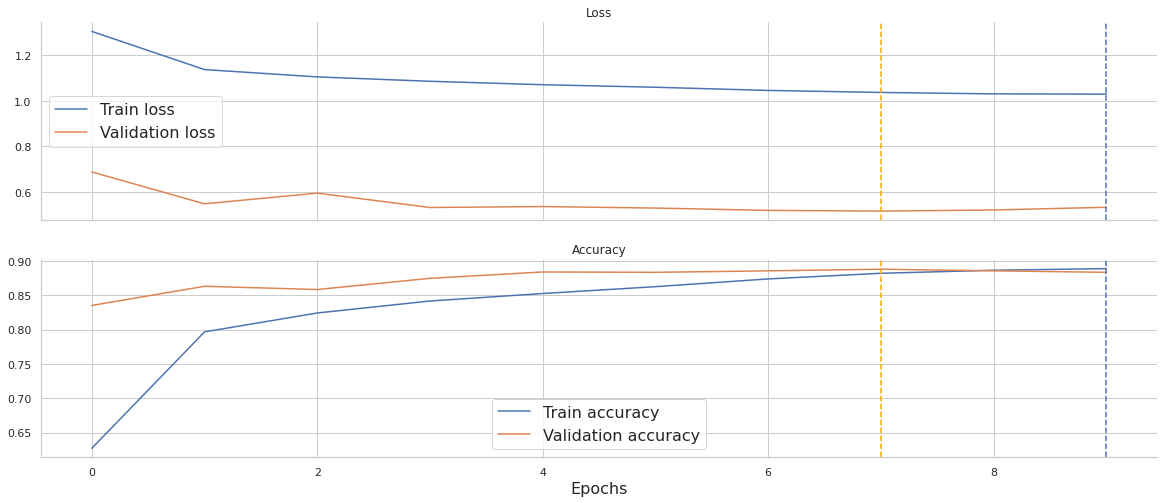


FOLD: 2


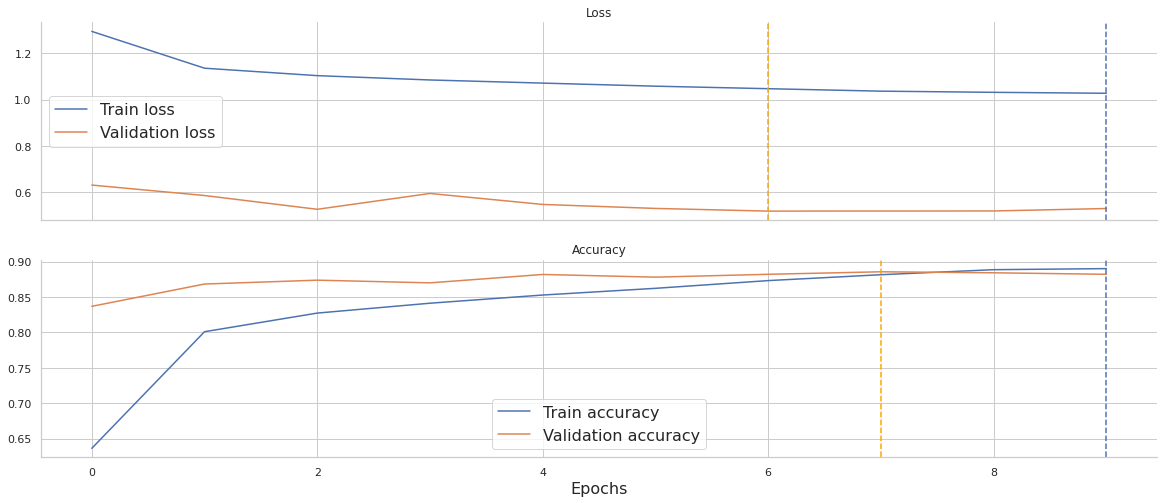


FOLD: 3


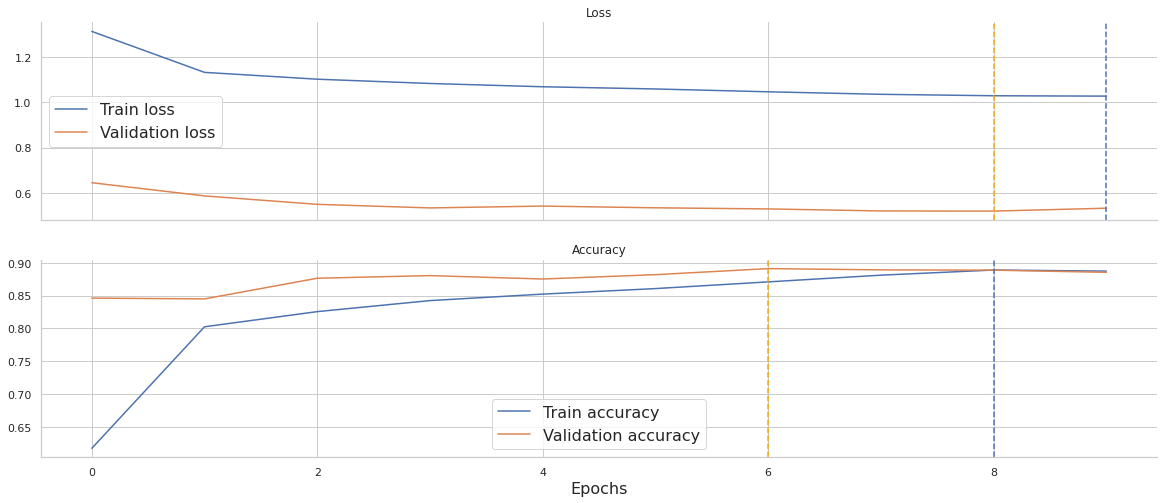


FOLD: 4


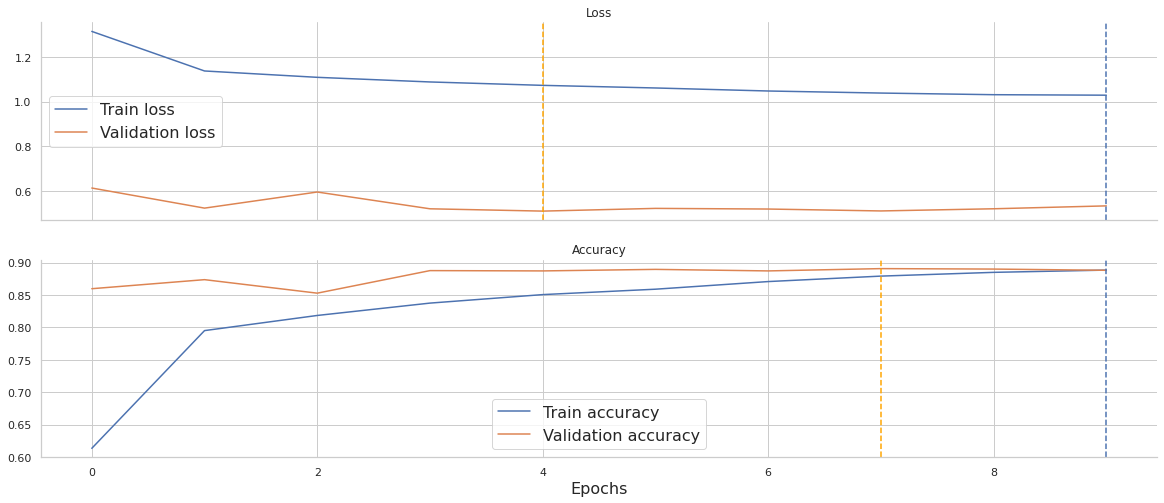


FOLD: 5


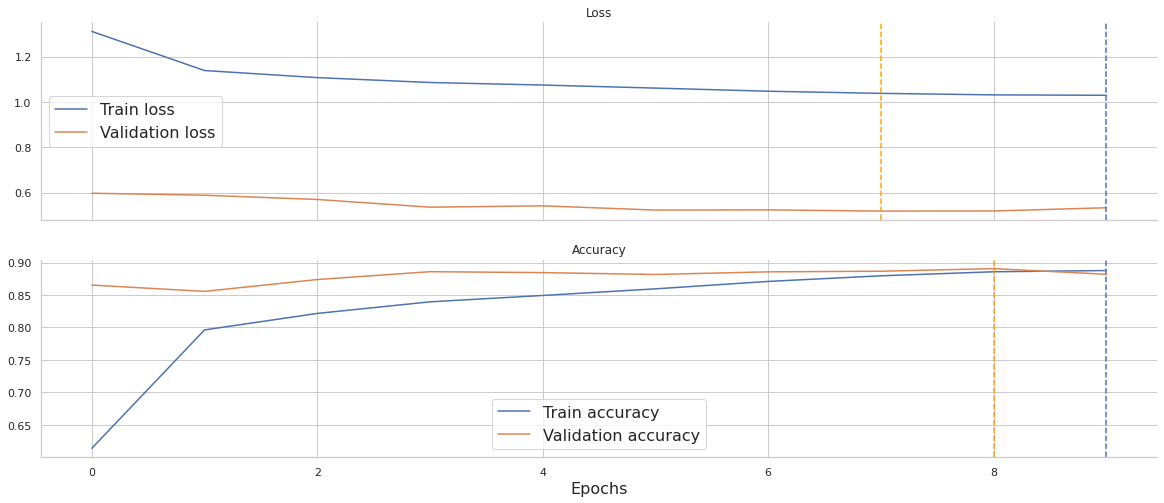

In [21]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

We are evaluating the model on the `OOF` predictions, it stands for `Out Of Fold`, since we are training using `K-Fold` our model will see all the data, and the correct way to evaluate each fold is by looking at the predictions that are not from that fold.

## OOF metrics

#### I am still having some problems to get the real model `OOF` scores while using `TPU Pods`, so the results here and the confusion matrix are just placeholders.

In [22]:
y_true = np.concatenate(oof_labels)
y_true = np.argmax(y_true, axis=-1)
y_pred = np.concatenate(oof_pred)

print(classification_report(y_true, y_pred, target_names=CLASSES))

                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.66      0.67      0.67      1086
Cassava Brown Streak Disease       0.83      0.82      0.82      2189
        Cassava Green Mottle       0.84      0.78      0.81      2386
      Cassava Mosaic Disease       0.95      0.97      0.96     13158
                     Healthy       0.75      0.74      0.74      2576

                    accuracy                           0.89     21395
                   macro avg       0.81      0.80      0.80     21395
                weighted avg       0.89      0.89      0.89     21395



# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

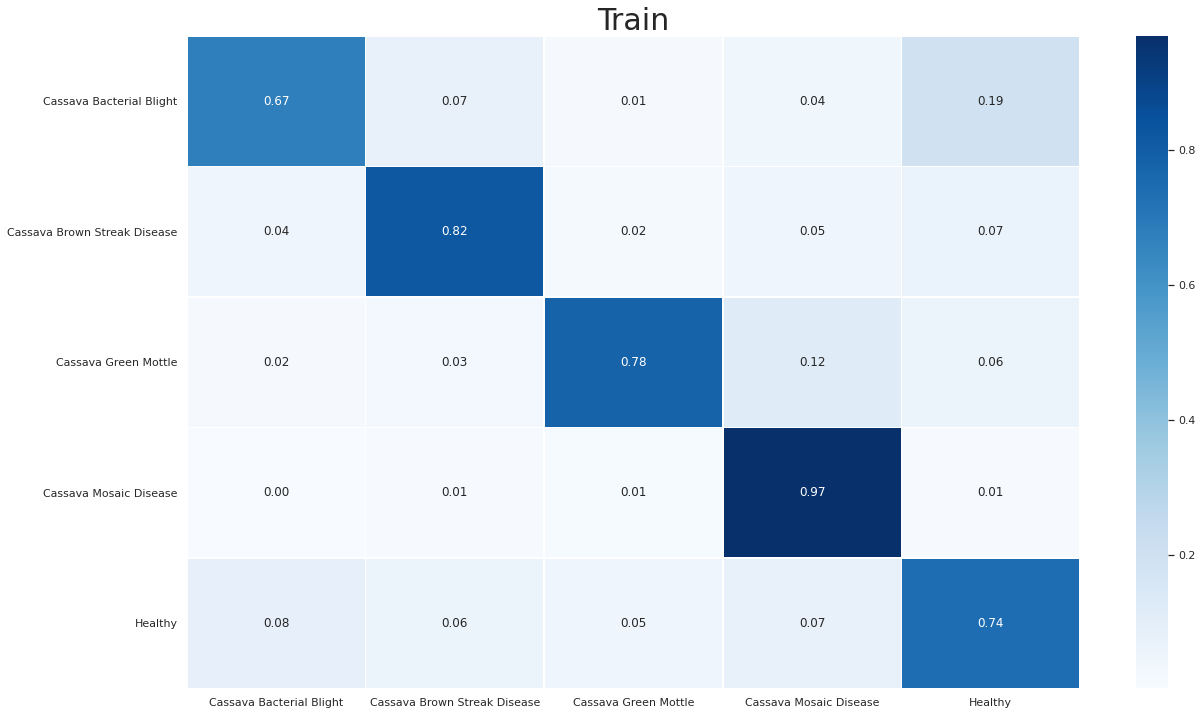

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, of if it is because the model is actually bad.


### Class map
```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```


## Train set

In [24]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
y_samp = np.argmax(y_samp, axis=-1)

x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
samp_preds_1 = model.predict(x_samp_1, batch_size=9)
display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
samp_preds_2 = model.predict(x_samp_2, batch_size=9)
display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)

Output hidden; open in https://colab.research.google.com to view.

In [25]:

save_data=True# You can immediately create a kaggle dataset from your models
if COLAB and save_data:
  
    import json


    
    data = {"title": "Cassava Leaf Disease", 
        "id": "aikhmelnytskyy/CassavaLeafDisease", 
        "licenses": [
                     {
                         "name": "CC0-1.0"
                      }
                     ]}
    

    # for kaggle api Connection
    
    !kaggle datasets init -p /content/drive/MyDrive/Colab Notebooks/Cassava/
    
    with open("/content/drive/MyDrive/Colab Notebooks/Cassava/dataset-metadata.json", "w", encoding="utf-8") as file:
        json.dump(data, file)
    
    #if new dataset
    !kaggle datasets create -p /content/drive/MyDrive/Models/Cassava/
    #If you’d like to upload a new version of an existing dataset
    #!kaggle datasets version -p /content/drive/MyDrive/Models/Cassava/ -m "Your message here"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
